In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="test")
location = geolocator.geocode(u"nashville")

print(location.address)       #住所
print(location.latitude)      #緯度
print(location.longitude)     #経度
print(location.raw)           #ジオコーディングした結果の全ての情報

Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States
36.1622767
-86.7742984
{'place_id': 298048751, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 197472, 'lat': '36.1622767', 'lon': '-86.7742984', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6474694013099324, 'addresstype': 'city', 'name': 'Nashville-Davidson', 'display_name': 'Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States', 'boundingbox': ['35.9677850', '36.4054960', '-87.0547660', '-86.5155880']}


In [143]:
import unicodedata
from pathlib import Path
!pip install scikit-learn==1.3.0

import os

!pip install catboost
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install category_encoders
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import TargetEncoder

from geopy.geocoders import Nominatim
# geolocator = Nominatim()

from geopy.extra.rate_limiter import RateLimiter
import time

In [144]:
INPUT_DIR = '/content/drive/MyDrive/signate/Student Cup 2023/input'

df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,NaN,5400
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054


In [145]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sub_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "price"])

In [146]:
train_df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [147]:
test_df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1495
odometer           0
title_status     229
transmission       0
drive              0
size               0
type             229
paint_color        0
state           3029
dtype: int64

In [148]:
train_df['state'].unique()

array([nan, 'pa', 'ks', 'ny', 'ca', 'al', 'or', 'va', 'mt', 'nj', 'ma',
       'wi', 'sc', 'wa', 'dc', 'oh', 'in', 'de', 'fl', 'nm', 'az', 'ok',
       'mn', 'co', 'nv', 'wv', 'tn', 'mi', 'ri', 'il', 'tx', 'ut', 'ia',
       'ga', 'md', 'mo', 'ky', 'nc', 'ak', 'id', 'ct', 'wy', 'nd', 'me',
       'ar', 'hi', 'sd', 'ne', 'nh', 'vt', 'la', 'ms'], dtype=object)

In [149]:
# region -> stateが一意に定まることを確認
region_state = {region:{} for region in train_df['region'].unique()}
for row, value in train_df.iterrows():
    if not pd.isna(value['state']):
        if value['state'] not in region_state[value['region']]:
            region_state[value['region']][value['state']] = 1
        else:
            region_state[value['region']][value['state']] += 1

for region, state_dict in region_state.items():
    if len(state_dict) > 1 or state_dict == {}:
        region_state[region] = pd.NA
    else:
        region_state[region] = list(state_dict.keys())[0]

# regionからstateを決定
train_df['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(train_df['region'], train_df['state'])]
test_df['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(test_df['region'], test_df['state'])]

In [150]:
agg_col = [
    'region',
    "cylinders",
    "manufacturer",
    # "condition",
    # "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
    # "country",
    # "color_category"
]
# manufacturer  paint_color v

for x in agg_col:
    grouped = train_df.groupby(x)['odometer']
    agg_data = grouped.agg(
        **{
            f"{x}_median_odometer": 'median',
            f"{x}_mean_odometer": 'mean'
        }
    ).reset_index()

    # 元のデータフレームに計算結果をマージ
    train_df = train_df.merge(agg_data, on=x, how='left')
    test_df = test_df.merge(agg_data, on=x, how='left')

In [151]:
# yearが3000年以降のものはおかしいので2000年に置換
err_idx = train_df.query("year >= 3000").index
train_df.loc[err_idx, "year"] = train_df.loc[err_idx, "year"].apply(lambda x: x - 1000)

# 走行距離 / 製造年
train_df["odometer_per_year"] = train_df["odometer"] / (2023 - train_df["year"])

In [152]:
# yearが3000年以降のものはおかしいので2000年に置換
err_idx = test_df.query("year >= 3000").index
test_df.loc[err_idx, "year"] = test_df.loc[err_idx, "year"].apply(lambda x: x - 1000)

# 走行距離 / 製造年
test_df["odometer_per_year"] = test_df["odometer"] / (2023 - test_df["year"])

In [153]:
for x in agg_col:
    grouped = train_df.groupby(x)['odometer_per_year']
    agg_data = grouped.agg(
        **{
            f"{x}_median_odometer_per_year": 'median',
            f"{x}_mean_odometer_per_year": 'mean'
        }
    ).reset_index()

    # 元のデータフレームに計算結果をマージ
    train_df = train_df.merge(agg_data, on=x, how='left')
    test_df = test_df.merge(agg_data, on=x, how='left')

In [154]:
train_df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,...,drive_median_odometer_per_year,drive_mean_odometer_per_year,size_median_odometer_per_year,size_mean_odometer_per_year,type_median_odometer_per_year,type_mean_odometer_per_year,paint_color_median_odometer_per_year,paint_color_mean_odometer_per_year,state_median_odometer_per_year,state_mean_odometer_per_year
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,...,5361.355903,5993.345684,8778.090909,9835.404266,5235.318125,5850.644018,4858.912500,5826.843929,7430.416667,8384.328259
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,...,5361.355903,5993.345684,7858.875000,8826.199819,9069.909091,10034.037476,9434.600000,10441.247719,8678.500000,9565.384014
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,...,9201.041667,10272.218278,7858.875000,8826.199819,9256.875000,10469.126355,9434.600000,10441.247719,8052.100000,8911.116603
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,...,9201.041667,10272.218278,8778.090909,9835.404266,9256.875000,10469.126355,8602.000000,9876.921532,8330.075758,9324.374580
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,...,9201.041667,10272.218278,8778.090909,9835.404266,9069.909091,10034.037476,8111.000000,9206.404291,8532.335417,9454.566284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,...,5361.355903,5993.345684,9605.377778,10759.751166,7273.925926,8306.532678,8484.416667,9489.091770,8678.500000,9565.384014
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,...,5361.355903,5993.345684,7858.875000,8826.199819,7191.486111,8155.232773,8484.416667,9489.091770,8283.359477,9163.098386
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,...,8665.299242,9876.414648,8778.090909,9835.404266,9256.875000,10469.126355,7712.700000,8536.478779,8330.075758,9324.374580
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,...,8665.299242,9876.414648,8778.090909,9835.404266,9069.909091,10034.037476,7712.700000,8536.478779,8330.075758,9324.374580


In [155]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    # X["title_status"] = X["title_status"].fillna("clean")

    # cylinderから数値を取り出す
    X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")
    # X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").fillna(0).astype("float32")


    # sizeの表記揺れを修正
    X["size"] = X["size"].str.replace("ー", "-").astype(str)
    X["size"] = X["size"].str.replace("−", "-").astype(str)

    # 順位付け: サイズ別に値を割り当てます。大きいほど高い値にします。
    ranking_dict = {'full-size': 4, 'mid-size': 3, 'compact': 2, 'sub-compact': 1}

    # 新しい順位カラムを作成します。
    X['size_rank'] = X['size'].map(ranking_dict)

    # manufacturerの表記揺れを修正
    X["manufacturer"] = X["manufacturer"].apply(
        lambda x: unicodedata.normalize("NFKC", x).lower()
    )

    # 正規化の辞書
    normalize_dict = {
        'niѕsan': 'nissan',
        'subαru': 'subaru',
        'toyotа': 'toyota',
        'sαturn': 'saturn',
        'аcura': 'acura',
        'vоlkswagen': 'volkswagen',
        'lexuѕ': 'lexus',
        'ᴄhrysler': 'chrysler'
    }


    # データフレームのメーカー名を正規化
    X['manufacturer'] = X['manufacturer'].map(lambda x: normalize_dict.get(x, x))

    # 国別分類
    def classify_country(manufacturer):
        if pd.isnull(manufacturer):
            return 'Unknown'
        if manufacturer in ['bmw', 'volkswagen', 'audi', 'mercedes-benz', 'porsche']:
            return 'Germany'
        elif manufacturer in ['toyota', 'nissan', 'lexus', 'subaru', 'honda', 'mazda', 'mitsubishi', 'infiniti', 'acura']:
            return 'Japan'
        elif manufacturer in ['ford', 'buick', 'ram', 'dodge', 'chevrolet', 'jeep', 'chrysler', 'gmc', 'lincoln', 'cadillac', 'pontiac', 'saturn']:
            return 'USA'
        elif manufacturer in ['hyundai', 'kia']:
            return 'South Korea'
        elif manufacturer in ['fiat', 'alfa-romeo']:
            return 'Italy'
        elif manufacturer in ['land rover', 'jaguar', 'aston-martin', 'rover']:
            return 'UK'
        else:
            return 'Unknown'

    X['country'] = X['manufacturer'].apply(classify_country)


    def classify_color(color):
        if color in ['orange', 'yellow', 'red', 'white']:
            return 'Bright'
        elif color in ['black', 'brown', 'green', 'blue']:
            return 'Dark'
        elif color in ['silver', 'grey']:
            return 'Neutral'
        elif color in ['purple', 'custom']:
            return 'Special'
        else:
            return 'Unknown'

    X['color_category'] = X['paint_color'].apply(classify_color)

    # one-hot encoding
    # X = pd.get_dummies(X, columns=['country'])

    # # yearが3000年以降のものはおかしいので2000年に置換
    # err_idx = X.query("year >= 3000").index
    # X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

    # # 走行距離 / 製造年
    # X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

    for col in agg_col:
      X[f"{col}_diff_mean"] = X["odometer"] - X[f"{x}_mean_odometer"]
      X[f"{col}_diff_median"] = X["odometer"] - X[f"{x}_median_odometer"]

    # X["pass_year"] = 2023 - X["year"]

    # X['state'] = X['state'].replace('<NA>', 'null')
    # X.dropna(subset=['state'], inplace=True)
    X['state'] = X['state'].fillna("unknown")

    err_idx = X.query("odometer < -1").index
    X.loc[err_idx, "odometer"] = X.loc[err_idx, "odometer"].apply(lambda x: -1)

    # Geolocatorオブジェクトを作成
    geolocator = Nominatim(user_agent="gabikueh")

    # ユニークなregionを取得
    unique_regions = X['region'].unique()

    # 緯度経度の辞書を作成
    lat_lon_dict = {}

    for city in unique_regions:
        try:
            location = geolocator.geocode(city)
            if location:
                lat_lon_dict[city] = {'latitude': location.latitude, 'longitude': location.longitude}
                print(location.raw)  # ジオコーディングした結果の全ての情報
            else:
                lat_lon_dict[city] = {'latitude': None, 'longitude': None}
                print(f"Failed to geocode for city: {city}")
        except Exception as e:
            lat_lon_dict[city] = {'latitude': None, 'longitude': None}
            print(f"Error geocoding city: {city}. Error message: {e}")

    # ユニークな地域の緯度経度を元のデータフレームにマージ
    geo_df = pd.DataFrame.from_dict(lat_lon_dict, orient='index').reset_index().rename(columns={'index': 'region'})
    X = X.merge(geo_df, on='region', how='left')

    return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols

class CountTransformer(TransformerMixin, BaseEstimator):
    """CountEncoder"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.ce = CountEncoder(cols=X.columns.tolist(), handle_unknown=0)
        self.ce.fit(X)
        return self

    def transform(self, X):
        return self.ce.transform(X)

    def get_feature_names_out(self, input_features=None):
        return input_features


class AggTransformer(TransformerMixin, BaseEstimator):
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict):
        self.key = key
        self.numeric_cols = numeric_cols
        self.agg_func = agg_func

    def fit(self, X, y=None):
        X = X.copy()
        print(X.columns)
        X[self.key] = X[self.key].astype("category")
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
        print(self.agg_df)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

        return self

    def transform(self, X):
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.tolist()

In [156]:
result_od_agg_cols = [f"{x}_diff_od_{stat}" for x in agg_col for stat in ['mean', 'median']]
result_od_year_agg_cols = [f"{x}_diff_od__{stat}" for x in agg_col for stat in ['mean', 'median']]
numeric_cols = ["year", "odometer", "odometer_per_year", "size_rank",
                "latitude", "longitude"
                ] + result_od_agg_cols + result_od_year_agg_cols
categorical_cols = [
    'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
    "country",
    "color_category"
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            categorical_cols,
        ),
        (
            "cnt",
            CountTransformer(),
            categorical_cols,
        ),

    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)


{'place_id': 298048751, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 197472, 'lat': '36.1622767', 'lon': '-86.7742984', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6474694013099324, 'addresstype': 'city', 'name': 'Nashville-Davidson', 'display_name': 'Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States', 'boundingbox': ['35.9677850', '36.4054960', '-87.0547660', '-86.5155880']}
{'place_id': 299449022, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 188627, 'lat': '40.7944504', 'lon': '-77.8616386', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.46200246531290373, 'addresstype': 'city', 'name': 'State College', 'display_name': 'State College, Centre County, Pennsylvania, United States', 'boundingbox': ['40.7683701', '40.8072297', '-77.8861677', '-77

{'place_id': 297950523, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 53292, 'lat': '41.000028', 'lon': '19.9999619', 'class': 'boundary', 'type': 'administrative', 'place_rank': 4, 'importance': 0.7279117988937367, 'addresstype': 'country', 'name': 'Shqipëria', 'display_name': 'Shqipëria', 'boundingbox': ['39.6403940', '42.6610848', '19.0009866', '21.0574335']}


{'place_id': 297981723, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 112503, 'lat': '40.5863563', 'lon': '-122.391675', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4996982408559731, 'addresstype': 'city', 'name': 'Redding', 'display_name': 'Redding, Shasta County, CAL Fire Northern Region, California, United States', 'boundingbox': ['40.4689190', '40.6794980', '-122.4538640', '-122.2735910']}


{'place_id': 101670004, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 7778734, 'lat': '34.814598', 'lon': '-87.642344', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000009999999993, 'addresstype': 'road', 'name': 'Muscle Shoals Drive', 'display_name': 'Muscle Shoals Drive, Weeden Heights, Florence, Lauderdale County, Alabama, 35630, United States', 'boundingbox': ['34.8142840', '34.8148478', '-87.6426788', '-87.6419570']}
{'place_id': 136103382, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 129284285, 'lat': '44.6172766', 'lon': '-124.0473054345423', 'class': 'tourism', 'type': 'aquarium', 'place_rank': 30, 'importance': 0.3054395124350446, 'addresstype': 'tourism', 'name': 'Oregon Coast Aquarium', 'display_name': 'Oregon Coast Aquarium, 2820, Southeast Ferry Slip Road, South Beach, Newport, Lincoln County, Oregon, 97365

{'place_id': 298785847, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 5396194, 'lat': '38.8950368', 'lon': '-77.0365427', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.7492888986115819, 'addresstype': 'city', 'name': 'Washington', 'display_name': 'Washington, District of Columbia, United States', 'boundingbox': ['38.7916303', '38.9959680', '-77.1197949', '-76.9093660']}
{'place_id': 298545436, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 2866486, 'lat': '33.8246269', 'lon': '-116.540303', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5405527724738972, 'addresstype': 'city', 'name': 'Palm Springs', 'display_name': 'Palm Springs, Riverside County, California, United States', 'boundingbox': ['33.6124222', '33.9319778', '-116.7120868', '-116.4428048']}
{'place_id': 404938, 'lice

{'place_id': 298048673, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 197353, 'lat': '35.9603948', 'lon': '-83.9210261', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5757741979978174, 'addresstype': 'city', 'name': 'Knoxville', 'display_name': 'Knoxville, Knox County, East Tennessee, Tennessee, United States', 'boundingbox': ['35.8494970', '36.0674280', '-84.1616250', '-83.6885430']}


{'place_id': 360112185, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 392915, 'lat': '41.7962409', 'lon': '-71.5992372', 'class': 'boundary', 'type': 'administrative', 'place_rank': 8, 'importance': 0.688026902639812, 'addresstype': 'state', 'name': 'Rhode Island', 'display_name': 'Rhode Island, United States', 'boundingbox': ['41.0958340', '42.0189359', '-71.9074310', '-71.0885710']}
{'place_id': 298050512, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 206857, 'lat': '38.4493315', 'lon': '-78.8688833', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5048765925469352, 'addresstype': 'city', 'name': 'Harrisonburg', 'display_name': 'Harrisonburg, Virginia, United States', 'boundingbox': ['38.3897660', '38.4895289', '-78.9178710', '-78.8243196']}
{'place_id': 297985796, 'licence': 'Data © OpenStreetMap contributors

Error geocoding city: northern michigan. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=northern+michigan&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 298358354, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 186761, 'lat': '44.0581728', 'lon': '-121.3153096', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.49505362854050977, 'addresstype': 'city', 'name': 'Bend', 'display_name': 'Bend, Deschutes County, Oregon, United States', 'boundingbox': ['43.9990630', '44.1237516', '-121.3824328', '-121.2433494']}
{'place_id': 297972121, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 112277, 'lat': '38.2544472', 'lon': '-104.609141'

{'place_id': 297998244, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 133345, 'lat': '39.2908816', 'lon': '-76.610759', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.655295117264336, 'addresstype': 'city', 'name': 'Baltimore', 'display_name': 'Baltimore, Maryland, United States', 'boundingbox': ['39.1972328', '39.3719992', '-76.7112977', '-76.5296757']}


{'place_id': 298006922, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 141008, 'lat': '39.100105', 'lon': '-94.5781416', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6305605306333077, 'addresstype': 'city', 'name': 'Kansas City', 'display_name': 'Kansas City, Jackson County, Missouri, United States', 'boundingbox': ['38.8271760', '39.3566620', '-94.7659170', '-94.3855220']}
{'place_id': 362775285, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 182706, 'lat': '39.9622601', 'lon': '-83.0007065', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6294399106820546, 'addresstype': 'city', 'name': 'Columbus', 'display_name': 'Columbus, Franklin County, Ohio, United States', 'boundingbox': ['39.8086936', '40.1573082', '-83.2101797', '-82.7713119']}
{'place_id': 298419510, 'licence': 'Data

{'place_id': 298071550, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 253988, 'lat': '27.7635302', 'lon': '-97.4033191', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5793731971939862, 'addresstype': 'city', 'name': 'Corpus Christi', 'display_name': 'Corpus Christi, Nueces County, Texas, United States', 'boundingbox': ['27.4835690', '27.8996380', '-97.6827420', '-96.9611080']}
{'place_id': 365390917, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 122604, 'lat': '41.8755616', 'lon': '-87.6244212', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.7515295727100249, 'addresstype': 'city', 'name': 'Chicago', 'display_name': 'Chicago, Cook County, Illinois, United States', 'boundingbox': ['41.6445310', '42.0230396', '-87.9401010', '-87.5240812']}
{'place_id': 298368183, 'licence': 'Dat

{'place_id': 350094356, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 251414, 'lat': '43.8122836', 'lon': '-91.2514355', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5067426007047761, 'addresstype': 'city', 'name': 'La Crosse', 'display_name': 'La Crosse, La Crosse County, Wisconsin, United States', 'boundingbox': ['43.7460200', '43.8983845', '-91.2759370', '-91.1570890']}
{'place_id': 355412804, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 207359, 'lat': '34.0536909', 'lon': '-118.242766', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.7738053728457621, 'addresstype': 'city', 'name': 'Los Angeles', 'display_name': 'Los Angeles, Los Angeles County, CAL Fire Contract Counties, California, United States', 'boundingbox': ['33.6595410', '34.3373060', '-118.6681779', '-118.155294

{'place_id': 298362089, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 161991, 'lat': '43.1700264', 'lon': '-107.568534', 'class': 'boundary', 'type': 'administrative', 'place_rank': 8, 'importance': 0.6907066410272007, 'addresstype': 'state', 'name': 'Wyoming', 'display_name': 'Wyoming, United States', 'boundingbox': ['40.9948223', '45.0058281', '-111.0552665', '-104.0523858']}
{'place_id': 298034740, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 181934, 'lat': '41.1035786', 'lon': '-80.6520161', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5337415510038925, 'addresstype': 'city', 'name': 'Youngstown', 'display_name': 'Youngstown, Mahoning County, Ohio, United States', 'boundingbox': ['41.0499533', '41.1390130', '-80.7111792', '-80.5679320']}
{'place_id': 117063522, 'licence': 'Data © OpenStreetMap contributo

{'place_id': 298034835, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 166563, 'lat': '19.593801499999998', 'lon': '-155.42837009716908', 'class': 'boundary', 'type': 'administrative', 'place_rank': 8, 'importance': 0.7204326433963092, 'addresstype': 'state', 'name': 'Hawaii', 'display_name': 'Hawaii, United States', 'boundingbox': ['18.8654600', '28.5172690', '-178.4435930', '-154.7557920']}
{'place_id': 297993913, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 127238, 'lat': '51.0612766', 'lon': '-1.3131692', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5511292080624068, 'addresstype': 'city', 'name': 'Winchester', 'display_name': 'Winchester, Hampshire, England, United Kingdom', 'boundingbox': ['50.8551173', '51.1969996', '-1.4565076', '-1.0339108']}
{'place_id': 156182519, 'licence': 'Data © OpenStreetMap c

{'place_id': 298552602, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 109847, 'lat': '32.2998686', 'lon': '-90.1830408', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5707152361890376, 'addresstype': 'city', 'name': 'Jackson', 'display_name': 'Jackson, Hinds County, Mississippi, United States', 'boundingbox': ['32.1955013', '32.4124415', '-90.3299278', '-90.0636172']}
{'place_id': 298122582, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 396496, 'lat': '35.3540209', 'lon': '-120.3757163', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5540102661244095, 'addresstype': 'county', 'name': 'San Luis Obispo County', 'display_name': 'San Luis Obispo County, California, United States', 'boundingbox': ['34.8975179', '35.7966550', '-121.4381760', '-119.4726201']}
{'place_id': 103527969, 

Error geocoding city: east oregon. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=east+oregon&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 124276133, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 83337046, 'lat': '41.6700891', 'lon': '-70.32877031452514', 'class': 'place', 'type': 'island', 'place_rank': 17, 'importance': 0.32500009999999996, 'addresstype': 'island', 'name': 'Gooseberry Island', 'display_name': 'Gooseberry Island, Centerville, Barnstable, Barnstable County, Massachusetts, United States', 'boundingbox': ['41.6699076', '41.6702877', '-70.3292050', '-70.3283723']}
{'place_id': 177450169, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 296971301, 'lat

Failed to geocode for city: raleigh / durham / CH
{'place_id': 298648601, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 396505, 'lat': '34.4458248', 'lon': '-119.0779359', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5603691549944142, 'addresstype': 'county', 'name': 'Ventura County', 'display_name': 'Ventura County, CAL Fire Contract Counties, California, United States', 'boundingbox': ['33.1634930', '34.9012713', '-119.7577028', '-118.6324850']}
{'place_id': 364757023, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1411339, 'lat': '39.7392364', 'lon': '-104.984862', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.595475873909579, 'addresstype': 'city', 'name': 'Denver', 'display_name': 'Denver, Colorado, United States', 'boundingbox': ['39.6143008', '39.9142087', '-105.109884

{'place_id': 74616704, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 6960225496, 'lat': '41.6656145', 'lon': '-86.2145865', 'class': 'shop', 'type': 'bed', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'shop', 'name': 'Mattress Clearance Center of Michiana', 'display_name': 'Mattress Clearance Center of Michiana, Mishawaka Avenue, South Bend, Saint Joseph County, Indiana, 46615, United States', 'boundingbox': ['41.6655645', '41.6656645', '-86.2146365', '-86.2145365']}
{'place_id': 298001383, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 134997, 'lat': '42.7337712', 'lon': '-84.5553805', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5559259042730303, 'addresstype': 'city', 'name': 'Lansing', 'display_name': 'Lansing, Ingham County, Michigan, United States', 'boundingbox': ['42.6474830', '42.7

{'place_id': 297984074, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 113253, 'lat': '27.5030915', 'lon': '-99.5075644', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5604176926349503, 'addresstype': 'city', 'name': 'Laredo', 'display_name': 'Laredo, Webb County, Texas, United States', 'boundingbox': ['27.3664121', '27.7444122', '-99.7503179', '-99.3310257']}
{'place_id': 338414585, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 1081048281, 'lat': '41.1232795', 'lon': '-82.2359215', 'class': 'railway', 'type': 'abandoned', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'railway', 'name': 'Lorain, Ashland, and Southern Railroad', 'display_name': 'Lorain, Ashland, and Southern Railroad, McMillan Road, Huntington Township, Lorain County, Ohio, United States', 'boundingbox': ['41.0948756', '41.148

{'place_id': 299688823, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1804307, 'lat': '38.2542376', 'lon': '-85.759407', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6196532156538946, 'addresstype': 'city', 'name': 'Louisville', 'display_name': 'Louisville, Jefferson County, Kentucky, United States', 'boundingbox': ['37.9971000', '38.3801391', '-85.9470644', '-85.4051000']}
{'place_id': 298044498, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 180348, 'lat': '35.595076', 'lon': '-82.5528478', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5473060759496394, 'addresstype': 'city', 'name': 'Asheville', 'display_name': 'Asheville, Buncombe County, North Carolina, United States', 'boundingbox': ['35.4164642', '35.6560763', '-82.6703643', '-82.4604691']}
{'place_id': 298234029, 'lic

{'place_id': 298560958, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 130140, 'lat': '39.049011', 'lon': '-95.677556', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5541024841955382, 'addresstype': 'city', 'name': 'Topeka', 'display_name': 'Topeka, Shawnee County, Kansas, United States', 'boundingbox': ['38.9171930', '39.1094000', '-95.8122630', '-95.6019399']}
Failed to geocode for city: roswell / carlsbad
{'place_id': 297985968, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 119016, 'lat': '30.421309', 'lon': '-87.2169149', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5520252296498929, 'addresstype': 'city', 'name': 'Pensacola', 'display_name': 'Pensacola, Escambia County, Florida, United States', 'boundingbox': ['30.3955428', '30.5104858', '-87.2588885', '-87.1497213']}
{'

{'place_id': 297981927, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 111477, 'lat': '36.0625843', 'lon': '-94.1574328', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5360588708728855, 'addresstype': 'city', 'name': 'Fayetteville', 'display_name': 'Fayetteville, Washington County, Arkansas, United States', 'boundingbox': ['35.9893558', '36.1489329', '-94.2978481', '-94.0267113']}
{'place_id': 47016291, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 4059014099, 'lat': '31.893739', 'lon': '-102.2841562', 'class': 'place', 'type': 'neighbourhood', 'place_rank': 20, 'importance': 0.25000009999999995, 'addresstype': 'neighbourhood', 'name': 'Odessa Country Club', 'display_name': 'Odessa Country Club, Midland County, Texas, United States', 'boundingbox': ['31.8837390', '31.9037390', '-102.2941562', '-102.2741562']}
{'pla

{'place_id': 298041664, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 126133, 'lat': '40.1117174', 'lon': '-88.207301', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5374327201980995, 'addresstype': 'city', 'name': 'Urbana', 'display_name': 'Urbana, Champaign County, Illinois, United States', 'boundingbox': ['40.0695490', '40.1573390', '-88.3186160', '-88.1530600']}
{'place_id': 415973, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 154182593, 'lat': '35.7309716', 'lon': '-80.3153309', 'class': 'place', 'type': 'hamlet', 'place_rank': 20, 'importance': 0.25000009999999995, 'addresstype': 'hamlet', 'name': 'Jersey', 'display_name': 'Jersey, Davidson County, North Carolina, United States', 'boundingbox': ['35.7109716', '35.7509716', '-80.3353309', '-80.2953309']}
{'place_id': 298099825, 'licence': 'Data © OpenStreetM

{'place_id': 298054884, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 188218, 'lat': '40.2663107', 'lon': '-76.8861122', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5747060943184734, 'addresstype': 'city', 'name': 'Harrisburg', 'display_name': 'Harrisburg, Dauphin County, Pennsylvania, United States', 'boundingbox': ['40.2375710', '40.3262914', '-76.9244900', '-76.8363940']}
{'place_id': 298362197, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 206561, 'lat': '37.270973', 'lon': '-79.9414313', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5295526704028372, 'addresstype': 'city', 'name': 'Roanoke', 'display_name': 'Roanoke, Virginia, United States', 'boundingbox': ['37.2118995', '37.3376132', '-80.0374765', '-79.8785498']}
{'place_id': 77825740, 'licence': 'Data © OpenStreetM

{'place_id': 241993101, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 684519299, 'lat': '42.3389377', 'lon': '-83.03870283998197', 'class': 'landuse', 'type': 'construction', 'place_rank': 22, 'importance': 0.2000099999999999, 'addresstype': 'construction', 'name': 'Lafayette West', 'display_name': 'Lafayette West, Lafayette Park, Detroit, Wayne County, Michigan, United States', 'boundingbox': ['42.3377107', '42.3398666', '-83.0399769', '-83.0374566']}
{'place_id': 298649703, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 3909995, 'lat': '41.764582', 'lon': '-72.6908547', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5957226153289852, 'addresstype': 'city', 'name': 'Hartford', 'display_name': 'Hartford, Capitol Planning Region, Connecticut, United States', 'boundingbox': ['41.7236703', '41.8074191', '-72.7180372', '

{'place_id': 230030597, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 608482607, 'lat': '41.31611085', 'lon': '-74.12629189225156', 'class': 'landuse', 'type': 'retail', 'place_rank': 22, 'importance': 0.2000000999999999, 'addresstype': 'retail', 'name': 'Hudson Valley', 'display_name': 'Hudson Valley, Village of Woodbury, Town of Woodbury, Orange County, New York, United States', 'boundingbox': ['41.3140017', '41.3183200', '-74.1284261', '-74.1240530']}
{'place_id': 299488325, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 11078268, 'lat': '38.0464066', 'lon': '-84.4970393', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5818846699201988, 'addresstype': 'city', 'name': 'Lexington', 'display_name': 'Lexington, Fayette County, Kentucky, United States', 'boundingbox': ['37.8452952', '38.2114040', '-84.6604150', '-84.28

{'place_id': 299848553, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 441183, 'lat': '37.9755648', 'lon': '23.7348324', 'class': 'place', 'type': 'city', 'place_rank': 15, 'importance': 0.7327228082131961, 'addresstype': 'city', 'name': 'Αθήνα', 'display_name': 'Αθήνα, Δήμος Αθηναίων, Περιφερειακή Ενότητα Κεντρικού Τομέα Αθηνών, Περιφέρεια Αττικής, Αποκεντρωμένη Διοίκηση Αττικής, 105 57, Ελλάς', 'boundingbox': ['37.8155648', '38.1355648', '23.5748324', '23.8948324']}
{'place_id': 297978998, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 111729, 'lat': '37.6390972', 'lon': '-120.9968782', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5313892163217817, 'addresstype': 'city', 'name': 'Modesto', 'display_name': 'Modesto, Stanislaus County, CAL Fire Southern Region, California, United States', 'boundingbox': ['37.521933

{'place_id': 137461, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 30674098, 'lat': '-23.5506507', 'lon': '-46.6333824', 'class': 'place', 'type': 'city', 'place_rank': 16, 'importance': 0.3500000999999999, 'addresstype': 'city', 'name': 'São Paulo', 'display_name': 'São Paulo, Região Imediata de São Paulo, Região Metropolitana de São Paulo, Região Geográfica Intermediária de São Paulo, São Paulo, Região Sudeste, Brasil', 'boundingbox': ['-23.7106507', '-23.3906507', '-46.7933824', '-46.4733824']}
{'place_id': 298019918, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 135028, 'lat': '42.291707', 'lon': '-85.5872286', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5379039258720391, 'addresstype': 'city', 'name': 'Kalamazoo', 'display_name': 'Kalamazoo, Kalamazoo County, Michigan, United States', 'boundingbox': ['42.21

{'place_id': 74254747, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 7022681126, 'lat': '40.508752', 'lon': '-88.9844947', 'class': 'railway', 'type': 'station', 'place_rank': 30, 'importance': 0.22254953489334617, 'addresstype': 'railway', 'name': 'Bloomington-Normal', 'display_name': 'Bloomington-Normal, 11, Uptown Circle, Uptown Normal, Normal, McLean County, Illinois, 61761, United States', 'boundingbox': ['40.5037520', '40.5137520', '-88.9894947', '-88.9794947']}
{'place_id': 298352437, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1907328, 'lat': '43.2484584', 'lon': '-86.129351', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.504396827215665, 'addresstype': 'county', 'name': 'Muskegon County', 'display_name': 'Muskegon County, Michigan, United States', 'boundingbox': ['43.1173984', '43.4724866', '-86.4617676

{'place_id': 71263690, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 6753734742, 'lat': '27.7712026', 'lon': '-82.6495453', 'class': 'amenity', 'type': 'bicycle_rental', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'amenity', 'name': 'Coast', 'display_name': 'Coast, Central Avenue, Methodist Town, Saint Petersburg, Pinellas County, Florida, 33707, United States', 'boundingbox': ['27.7711526', '27.7712526', '-82.6495953', '-82.6494953']}


{'place_id': 298001353, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 127319, 'lat': '37.970495', 'lon': '-87.5715641', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.539218141456688, 'addresstype': 'city', 'name': 'Evansville', 'display_name': 'Evansville, Vanderburgh County, Indiana, United States', 'boundingbox': ['37.9355880', '38.0568900', '-87.6375480', '-87.4498736']}
{'place_id': 94987995, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 9311645598, 'lat': '-28.1677446', 'lon': '153.5352458', 'class': 'healthcare', 'type': 'alternative', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'healthcare', 'name': '+ space', 'display_name': '+ space, 21, McLean Street, Coolangatta, Gold Coast City, Queensland, 4225, Australia', 'boundingbox': ['-28.1677946', '-28.1676946', '153.5351958', '153.535

{'place_id': 105296673, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 15074298, 'lat': '39.838066', 'lon': '-79.01503', 'class': 'railway', 'type': 'abandoned', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'railway', 'name': 'Western Maryland', 'display_name': 'Western Maryland, Pony Farm Road, Summit Township, Somerset County, Pennsylvania, 15552, United States', 'boundingbox': ['39.8307164', '39.8545960', '-79.0399865', '-78.9997470']}
Failed to geocode for city: appleton-oshkosh-FDL
{'place_id': 298155267, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 115401, 'lat': '33.5855677', 'lon': '-101.8470215', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5762048943652979, 'addresstype': 'city', 'name': 'Lubbock', 'display_name': 'Lubbock, Lubbock County, Texas, United States', 'boundingbox': ['

{'place_id': 297999276, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 131885, 'lat': '29.9759983', 'lon': '-90.0782127', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6080264379988477, 'addresstype': 'city', 'name': 'New Orleans', 'display_name': 'New Orleans, Orleans Parish, Louisiana, United States', 'boundingbox': ['29.8654809', '30.1994687', '-90.1399307', '-89.6251763']}


{'place_id': 298002497, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 135130, 'lat': '42.2681569', 'lon': '-83.7312291', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.537069344370284, 'addresstype': 'city', 'name': 'Ann Arbor', 'display_name': 'Ann Arbor, Washtenaw County, Michigan, United States', 'boundingbox': ['42.2226680', '42.3238941', '-83.7995720', '-83.6758070']}


{'place_id': 297980656, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 111293, 'lat': '35.3784666', 'lon': '-94.3996456', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5091299266096926, 'addresstype': 'city', 'name': 'Fort Smith', 'display_name': 'Fort Smith, Sebastian County, Arkansas, United States', 'boundingbox': ['35.2588549', '35.4498153', '-94.4355398', '-94.2528595']}


{'place_id': 297995266, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 127716, 'lat': '39.1670396', 'lon': '-86.5342881', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5579355155989937, 'addresstype': 'city', 'name': 'Bloomington', 'display_name': 'Bloomington, Monroe County, Indiana, United States', 'boundingbox': ['39.1213291', '39.2213618', '-86.5918944', '-86.4711305']}
{'place_id': 298335554, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1800895, 'lat': '38.2722313', 'lon': '-90.1792484', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5391300881685377, 'addresstype': 'county', 'name': 'Monroe County', 'display_name': 'Monroe County, Illinois, United States', 'boundingbox': ['38.0879113', '38.5217590', '-90.3730499', '-89.8967360']}
{'place_id': 298058742, 'licence': 'Data 

Failed to geocode for city: sioux falls / SE SD


{'place_id': 375624, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 153569360, 'lat': '47.4061859', 'lon': '-88.2003335', 'class': 'place', 'type': 'hamlet', 'place_rank': 20, 'importance': 0.25000999999999995, 'addresstype': 'hamlet', 'name': 'Central', 'display_name': 'Central, Houghton Township, Keweenaw County, Michigan, 49924, United States', 'boundingbox': ['47.3861859', '47.4261859', '-88.2203335', '-88.1803335']}
{'place_id': 298047936, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 194119, 'lat': '32.7884363', 'lon': '-79.9399309', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6015655328508253, 'addresstype': 'city', 'name': 'Charleston', 'display_name': 'Charleston, Charleston County, South Carolina, United States', 'boundingbox': ['32.6685050', '32.9735150', '-80.1438459', '-79.7970640']}


{'place_id': 473598, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 166654337, 'lat': '40.5887558', 'lon': '-75.564283', 'class': 'highway', 'type': 'motorway_junction', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'highway', 'name': 'Lehigh Valley', 'display_name': 'Lehigh Valley, Pennsylvania Turnpike Northeast Extension, South Whitehall Township, Lehigh County, Pennsylvania, 18106, United States', 'boundingbox': ['40.5887058', '40.5888058', '-75.5643330', '-75.5642330']}
{'place_id': 298360568, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1933719, 'lat': '42.3652226', 'lon': '-71.1843771', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.48566627779670657, 'addresstype': 'town', 'name': 'Watertown', 'display_name': 'Watertown, Middlesex County, Massachusetts, United States', 'boundingbox':

{'place_id': 233796719, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 629007170, 'lat': '35.9303536', 'lon': '-105.959369', 'class': 'highway', 'type': 'secondary', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Nambe Road', 'display_name': 'Nambe Road, Nambe Pueblo / Nambé Oweengé, Santa Fe County, New Mexico, 87522, United States', 'boundingbox': ['35.9009777', '35.9542275', '-105.9769196', '-105.9383553']}
{'place_id': 164516184, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 237909262, 'lat': '-43.4032468', 'lon': '146.5555293', 'class': 'waterway', 'type': 'river', 'place_rank': 19, 'importance': 0.27501, 'addresstype': 'river', 'name': 'New River', 'display_name': 'New River, Huon Valley, Tasmania, Australia', 'boundingbox': ['-43.5524926', '-43.2776543', '146.4647646', '146.6074419']}
{'place_id': 297999297, 'l

{'place_id': 362079224, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 182659, 'lat': '40.75839', 'lon': '-82.5154471', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4990262879924212, 'addresstype': 'town', 'name': 'Mansfield', 'display_name': 'Mansfield, Richland County, Ohio, United States', 'boundingbox': ['40.6886407', '40.8436307', '-82.5900433', '-82.4560819']}
{'place_id': 298056928, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 162378, 'lat': '52.4796992', 'lon': '-1.9026911', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6734272656139734, 'addresstype': 'city', 'name': 'Birmingham', 'display_name': 'Birmingham, West Midlands Combined Authority, England, United Kingdom', 'boundingbox': ['52.3810530', '52.6087058', '-2.0336486', '-1.7288417']}
{'place_id': 298062836, 'l

{'place_id': 297971540, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 110765, 'lat': '32.665135', 'lon': '-114.47603157249804', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5122362730840806, 'addresstype': 'city', 'name': 'Yuma', 'display_name': 'Yuma, Yuma County, Arizona, United States', 'boundingbox': ['32.6524020', '32.7262160', '-114.6590358', '-114.4660750']}
{'place_id': 298021341, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 133571, 'lat': '38.9786401', 'lon': '-76.492786', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5722443958642912, 'addresstype': 'city', 'name': 'Annapolis', 'display_name': 'Annapolis, Anne Arundel County, Maryland, United States', 'boundingbox': ['38.9424993', '39.0025548', '-76.5395832', '-76.4686762']}
{'place_id': 298057055, 'licence': 'Dat

{'place_id': 298732340, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 4644852, 'lat': '46.10545475', 'lon': '-89.97800809043656', 'class': 'boundary', 'type': 'protected_area', 'place_rank': 25, 'importance': 0.30799018260571026, 'addresstype': 'protected_area', 'name': 'Northern Highland American Legion State Forest', 'display_name': 'Northern Highland American Legion State Forest, Iron County, Wisconsin, United States', 'boundingbox': ['45.7323830', '46.2824526', '-90.0538537', '-89.3003112']}
Failed to geocode for city: lewiston / clarkston
{'place_id': 298029664, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 174933, 'lat': '42.098698', 'lon': '-75.9125187', 'class': 'boundary', 'type': 'administrative', 'place_rank': 14, 'importance': 0.5209771076092027, 'addresstype': 'city', 'name': 'City of Binghamton', 'display_name': 'City of Binghamto

{'place_id': 144305746, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 161404071, 'lat': '40.59276935', 'lon': '-105.07404828968387', 'class': 'leisure', 'type': 'park', 'place_rank': 24, 'importance': 0.15000009999999997, 'addresstype': 'park', 'name': 'Old Fort Collins Heritage Park', 'display_name': 'Old Fort Collins Heritage Park, Old Town North, Fort Collins, Larimer County, Colorado, United States', 'boundingbox': ['40.5912363', '40.5944658', '-105.0755318', '-105.0714938']}
{'place_id': 298446969, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 2504948, 'lat': '38.029306', 'lon': '-78.4766781', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5589801575461752, 'addresstype': 'city', 'name': 'Charlottesville', 'display_name': 'Charlottesville, Virginia, United States', 'boundingbox': ['38.0095927', '38.0705032', '-

{'place_id': 298154927, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 110732, 'lat': '34.2542084', 'lon': '-110.029832', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.41113533400689056, 'addresstype': 'city', 'name': 'Show Low', 'display_name': 'Show Low, Navajo County, Arizona, 85901, United States', 'boundingbox': ['34.1938670', '34.2870670', '-110.1084840', '-109.9810190']}
{'place_id': 215539177, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 504767148, 'lat': '46.74046085', 'lon': '-117.11616790689413', 'class': 'aeroway', 'type': 'aerodrome', 'place_rank': 30, 'importance': 0.29136025403149635, 'addresstype': 'aeroway', 'name': 'Pullman-Moscow Regional Airport', 'display_name': 'Pullman-Moscow Regional Airport, Pullman Moscow Airport Terminal, Pullman, Whitman County, Washington, 99164, United States', 'boundi

{'place_id': 202012364, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 423269898, 'lat': '46.3811136', 'lon': '-105.82484779798801', 'class': 'landuse', 'type': 'cemetery', 'place_rank': 22, 'importance': 0.2000000999999999, 'addresstype': 'cemetery', 'name': 'Eastern Montana State Veterans Cemetery', 'display_name': 'Eastern Montana State Veterans Cemetery, Miles City, Custer County, Montana, 59301, United States', 'boundingbox': ['46.3792317', '46.3828076', '-105.8277693', '-105.8225873']}
{'place_id': 107500712, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 19192199, 'lat': '39.9700862', 'lon': '-82.0089733', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Cambridge Avenue', 'display_name': 'Cambridge Avenue, Zanesville, Muskingum County, Ohio, 43701, United States', 'bound

{'place_id': 298334312, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1799705, 'lat': '42.321246', 'lon': '-88.8235511', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5382326327811843, 'addresstype': 'county', 'name': 'Boone County', 'display_name': 'Boone County, Illinois, United States', 'boundingbox': ['42.1523286', '42.4950185', '-88.9405900', '-88.7055866']}
{'place_id': 298124976, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 405844, 'lat': '38.1443725', 'lon': '-92.65947435867777', 'class': 'natural', 'type': 'water', 'place_rank': 22, 'importance': 0.3146916706215691, 'addresstype': 'water', 'name': 'Lake Of The Ozarks', 'display_name': 'Lake Of The Ozarks, Osage Beach, Camden County, Missouri, 65079, United States', 'boundingbox': ['37.9582476', '38.3305000', '-93.4059191', '-92.5264145']}
{'place_id'

{'place_id': 298029555, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 174979, 'lat': '42.4396039', 'lon': '-76.4968019', 'class': 'boundary', 'type': 'administrative', 'place_rank': 14, 'importance': 0.5459011398237105, 'addresstype': 'city', 'name': 'City of Ithaca', 'display_name': 'City of Ithaca, Ulysses, Tompkins County, New York, United States', 'boundingbox': ['42.4181672', '42.4669379', '-76.5270029', '-76.4699893']}
{'place_id': 298001454, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 137369, 'lat': '47.4785418', 'lon': '-94.8907869', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.49377947613683976, 'addresstype': 'town', 'name': 'Bemidji', 'display_name': 'Bemidji, Beltrami County, Minnesota, 56601, United States', 'boundingbox': ['47.4246641', '47.5269459', '-94.9492202', '-94.7999840']}


Error geocoding city: southern illinois. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=southern+illinois&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 298644762, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 3871059, 'lat': '30.40711375', 'lon': '-89.07143302103171', 'class': 'aeroway', 'type': 'aerodrome', 'place_rank': 30, 'importance': 0.2874189406975713, 'addresstype': 'aeroway', 'name': 'Gulfport-Biloxi International Airport', 'display_name': 'Gulfport-Biloxi International Airport, Airport Road, North Gulfport, Gulfport, Harrison County, Mississippi, 39503, United States', 'boundingbox': ['30.3937865', '30.4198528', '-89.0892407', '-89.0578847']}
{'place_id': 298445033, 'licence': 'Data © OpenStreetMap contributors, O

{'place_id': 218050136, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 521971846, 'lat': '30.1942384', 'lon': '-98.05324217912107', 'class': 'craft', 'type': 'distillery', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'craft', 'name': 'Deep Eddy Distillery', 'display_name': 'Deep Eddy Distillery, East US Highway 290, Dripping Springs, Hays County, Texas, United States', 'boundingbox': ['30.1939966', '30.1944601', '-98.0536134', '-98.0527623']}
{'place_id': 274543300, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 893839350, 'lat': '41.892231699999996', 'lon': '-103.68260709673888', 'class': 'amenity', 'type': 'university', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'amenity', 'name': 'University of Nebraska-Lincoln Panhandle Research and Extension Center', 'display_name': 'University of Nebraska-Lincoln Pa

Error geocoding city: del rio / eagle pass. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=del+rio+%2F+eagle+pass&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 289772407, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 1000038115, 'lat': '34.19768', 'lon': '-103.3246785', 'class': 'highway', 'type': 'trunk', 'place_rank': 26, 'importance': 0.10000009999999993, 'addresstype': 'road', 'name': 'Clovis Highway', 'display_name': 'Clovis Highway, Portales, Roosevelt County, New Mexico, 88130, United States', 'boundingbox': ['34.1930299', '34.2026760', '-103.3309645', '-103.3177082']}
{'place_id': 297996194, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 129229, 'lat'

{'place_id': 339261396, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 1083400825, 'lat': '42.6620502', 'lon': '-83.54580562782114', 'class': 'landuse', 'type': 'residential', 'place_rank': 22, 'importance': 0.2000099999999999, 'addresstype': 'residential', 'name': 'Cumberland Valley', 'display_name': 'Cumberland Valley, White Lake Charter Township, Oakland County, Michigan, United States', 'boundingbox': ['42.6591022', '42.6654566', '-83.5480340', '-83.5431225']}
{'place_id': 297971860, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 110720, 'lat': '33.9471315', 'lon': '-86.4714926', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4502362775822694, 'addresstype': 'city', 'name': 'Oneonta', 'display_name': 'Oneonta, Blount County, Alabama, 35121, United States', 'boundingbox': ['33.8773870', '33.9877020', '-86.5830930',

{'place_id': 154220464, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 198612567, 'lat': '40.7994286', 'lon': '-81.37471728711344', 'class': 'building', 'type': 'office', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'building', 'name': "Akron Children's Hospital - Canton CARE Center", 'display_name': "Akron Children's Hospital - Canton CARE Center, 213, Market Avenue North, Downtown Canton, Canton, Stark County, Ohio, 44702, United States", 'boundingbox': ['40.7993653', '40.7994944', '-81.3748702', '-81.3745644']}
{'place_id': 364757023, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1411339, 'lat': '39.7392364', 'lon': '-104.984862', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.595475873909579, 'addresstype': 'city', 'name': 'Denver', 'display_name': 'Denver, Colorado, United States', 'bound

{'place_id': 116939356, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 43723409, 'lat': '27.395988350000003', 'lon': '-82.55407423064528', 'class': 'aeroway', 'type': 'aerodrome', 'place_rank': 30, 'importance': 0.3627747144143258, 'addresstype': 'aeroway', 'name': 'Sarasota-Bradenton International Airport', 'display_name': 'Sarasota-Bradenton International Airport, 6000, Airport Circle, Sarasota, Sarasota County, Florida, 34243, United States', 'boundingbox': ['27.3820816', '27.4075423', '-82.5679974', '-82.5428381']}
{'place_id': 103962091, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 11594277, 'lat': '39.830107', 'lon': '-74.978493', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Central', 'display_name': 'Central, Gibbsboro, Camden County, New Jersey, 08026, United State

{'place_id': 415973, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 154182593, 'lat': '35.7309716', 'lon': '-80.3153309', 'class': 'place', 'type': 'hamlet', 'place_rank': 20, 'importance': 0.25000009999999995, 'addresstype': 'hamlet', 'name': 'Jersey', 'display_name': 'Jersey, Davidson County, North Carolina, United States', 'boundingbox': ['35.7109716', '35.7509716', '-80.3353309', '-80.2953309']}
{'place_id': 298047936, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 194119, 'lat': '32.7884363', 'lon': '-79.9399309', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6015655328508253, 'addresstype': 'city', 'name': 'Charleston', 'display_name': 'Charleston, Charleston County, South Carolina, United States', 'boundingbox': ['32.6685050', '32.9735150', '-80.1438459', '-79.7970640']}
{'place_id': 355412804, 'licence': 'Da

{'place_id': 297993995, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 127020, 'lat': '42.2713945', 'lon': '-89.093966', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5471515441527466, 'addresstype': 'city', 'name': 'Rockford', 'display_name': 'Rockford, Rockford Township, Winnebago County, Illinois, United States', 'boundingbox': ['42.1432458', '42.3386478', '-89.1952803', '-88.9408682']}
{'place_id': 357453229, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 10684569046, 'lat': '33.8583113', 'lon': '-118.0858136', 'class': 'highway', 'type': 'bus_stop', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'highway', 'name': 'South-Jersey', 'display_name': 'South-Jersey, South Street, Artesia, Los Angeles County, California, 90703, United States', 'boundingbox': ['33.8582613', '33.8583613', '-118.085

{'place_id': 298560958, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 130140, 'lat': '39.049011', 'lon': '-95.677556', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5541024841955382, 'addresstype': 'city', 'name': 'Topeka', 'display_name': 'Topeka, Shawnee County, Kansas, United States', 'boundingbox': ['38.9171930', '39.1094000', '-95.8122630', '-95.6019399']}
{'place_id': 298034842, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 182130, 'lat': '41.4996574', 'lon': '-81.6936772', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6460814677788097, 'addresstype': 'city', 'name': 'Cleveland', 'display_name': 'Cleveland, Cuyahoga County, Ohio, United States', 'boundingbox': ['41.3906280', '41.6044360', '-81.8790937', '-81.5327440']}
{'place_id': 298545436, 'licence': 'Data © OpenStre

{'place_id': 124276133, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 83337046, 'lat': '41.6700891', 'lon': '-70.32877031452514', 'class': 'place', 'type': 'island', 'place_rank': 17, 'importance': 0.32500009999999996, 'addresstype': 'island', 'name': 'Gooseberry Island', 'display_name': 'Gooseberry Island, Centerville, Barnstable, Barnstable County, Massachusetts, United States', 'boundingbox': ['41.6699076', '41.6702877', '-70.3292050', '-70.3283723']}


{'place_id': 297996483, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 128377, 'lat': '42.5006243', 'lon': '-90.6647985', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5222519473069606, 'addresstype': 'city', 'name': 'Dubuque', 'display_name': 'Dubuque, Dubuque County, Iowa, United States', 'boundingbox': ['42.4092568', '42.5579044', '-90.8240079', '-90.6367270']}
{'place_id': 250568740, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 734744959, 'lat': '40.96798855', 'lon': '29.142693109301383', 'class': 'leisure', 'type': 'park', 'place_rank': 24, 'importance': 0.15000999999999998, 'addresstype': 'park', 'name': 'Gold Country', 'display_name': 'Gold Country, Başıbüyük Mahallesi, Maltepe, İstanbul, Marmara Bölgesi, 34854, Türkiye', 'boundingbox': ['40.9663865', '40.9692017', '29.1395295', '29.1451085']}
{'place_id': 1

{'place_id': 298053960, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 198918, 'lat': '37.104153', 'lon': '-113.5841313', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4806669724438311, 'addresstype': 'city', 'name': 'Saint George', 'display_name': 'Saint George, Washington County, Utah, United States', 'boundingbox': ['36.9999740', '37.2095922', '-113.6497557', '-113.4768071']}
{'place_id': 298648601, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 396505, 'lat': '34.4458248', 'lon': '-119.0779359', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5603691549944142, 'addresstype': 'county', 'name': 'Ventura County', 'display_name': 'Ventura County, CAL Fire Contract Counties, California, United States', 'boundingbox': ['33.1634930', '34.9012713', '-119.7577028', '-118.6324850']}
{'

{'place_id': 299219018, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 7783199, 'lat': '46.56132435', 'lon': '-87.41048112721177', 'class': 'amenity', 'type': 'university', 'place_rank': 30, 'importance': 0.42173098883034005, 'addresstype': 'amenity', 'name': 'Northern Michigan University', 'display_name': 'Northern Michigan University, East Fair Avenue, Marquette, Marquette County, Michigan, 49855, United States', 'boundingbox': ['46.5551723', '46.5677273', '-87.4162346', '-87.3861668']}
Failed to geocode for city: altoona-johnstown
{'place_id': 299489310, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 11000241, 'lat': '34.539984', 'lon': '-112.468812', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5190275667551049, 'addresstype': 'city', 'name': 'Prescott', 'display_name': 'Prescott, Yavapai County, Arizona, U

{'place_id': 230030597, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 608482607, 'lat': '41.31611085', 'lon': '-74.12629189225156', 'class': 'landuse', 'type': 'retail', 'place_rank': 22, 'importance': 0.2000000999999999, 'addresstype': 'retail', 'name': 'Hudson Valley', 'display_name': 'Hudson Valley, Village of Woodbury, Town of Woodbury, Orange County, New York, United States', 'boundingbox': ['41.3140017', '41.3183200', '-74.1284261', '-74.1240530']}
{'place_id': 298136709, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 417768, 'lat': '40.08067', 'lon': '-76.2411283', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5509920588744114, 'addresstype': 'county', 'name': 'Lancaster County', 'display_name': 'Lancaster County, Pennsylvania, United States', 'boundingbox': ['39.7211039', '40.3157130', '-76.7219602', '-75.87

{'place_id': 298155267, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 115401, 'lat': '33.5855677', 'lon': '-101.8470215', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5762048943652979, 'addresstype': 'city', 'name': 'Lubbock', 'display_name': 'Lubbock, Lubbock County, Texas, United States', 'boundingbox': ['33.4478552', '33.7084347', '-102.0321210', '-101.7490053']}
{'place_id': 297999297, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 132139, 'lat': '32.5135356', 'lon': '-93.7477839', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5488806192499924, 'addresstype': 'city', 'name': 'Shreveport', 'display_name': 'Shreveport, Caddo Parish, Louisiana, United States', 'boundingbox': ['32.3326915', '32.5898665', '-93.9478451', '-93.6797150']}
{'place_id': 298065409, 'licence': 'Data 

Error geocoding city: southern illinois. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=southern+illinois&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 41222463, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 3283274165, 'lat': '36.8479165', 'lon': '-76.2902105', 'class': 'tourism', 'type': 'artwork', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'tourism', 'name': 'Hampton Roads', 'display_name': 'Hampton Roads, East City Hall Avenue, Downtown, Norfolk, Virginia, 23514, United States', 'boundingbox': ['36.8478665', '36.8479665', '-76.2902605', '-76.2901605']}
{'place_id': 297978998, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 111729

{'place_id': 298090985, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 251837, 'lat': '44.9596017', 'lon': '-89.6298239', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4881113312234592, 'addresstype': 'city', 'name': 'Wausau', 'display_name': 'Wausau, Marathon County, Wisconsin, 54403, United States', 'boundingbox': ['44.9185504', '45.0064424', '-89.7679330', '-89.5729183']}
{'place_id': 297940862, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 47796, 'lat': '52.2434979', 'lon': '5.6343227', 'class': 'boundary', 'type': 'administrative', 'place_rank': 6, 'importance': 0.8294168953690945, 'addresstype': 'country', 'name': 'Nederland', 'display_name': 'Nederland', 'boundingbox': ['11.8250000', '53.7443950', '-68.6255319', '7.2274985']}


{'place_id': 215739401, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 505558342, 'lat': '37.684171', 'lon': '-122.0996963', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000009999999993, 'addresstype': 'road', 'name': 'Medford Avenue', 'display_name': 'Medford Avenue, Cherryland, Alameda County, California, 94541, United States', 'boundingbox': ['37.6838398', '37.6845057', '-122.1001101', '-122.0992781']}
{'place_id': 100997272, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 5503470, 'lat': '44.6375553', 'lon': '-123.1063045', 'class': 'highway', 'type': 'trunk', 'place_rank': 26, 'importance': 0.2208608703737879, 'addresstype': 'road', 'name': 'Albany-Corvallis Highway', 'display_name': 'Albany-Corvallis Highway, North Albany, Albany, Linn County, Oregon, 97322, United States', 'boundingbox': ['44.6375553', '44.6408386', 

{'place_id': 298099825, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 287917, 'lat': '54.478530449999994', 'lon': '-3.06553306667584', 'class': 'boundary', 'type': 'protected_area', 'place_rank': 25, 'importance': 0.5191089117726843, 'addresstype': 'protected_area', 'name': 'Lake District National Park', 'display_name': 'Lake District National Park, England, United Kingdom', 'boundingbox': ['54.1933275', '54.7636771', '-3.4956715', '-2.5820556']}
{'place_id': 297995266, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 127716, 'lat': '39.1670396', 'lon': '-86.5342881', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5579355155989937, 'addresstype': 'city', 'name': 'Bloomington', 'display_name': 'Bloomington, Monroe County, Indiana, United States', 'boundingbox': ['39.1213291', '39.2213618', '-86.5918944', '-86.47113

{'place_id': 109362700, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 21131600, 'lat': '32.018738', 'lon': '-102.069351', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'North Tyler Street', 'display_name': 'North Tyler Street, Lynsie Neighborhood, Midland, Midland County, Texas, 79705, United States', 'boundingbox': ['32.0177250', '32.0197750', '-102.0695490', '-102.0690220']}
{'place_id': 297950113, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 62531, 'lat': '52.2646577', 'lon': '10.5236066', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.6188366331247037, 'addresstype': 'city', 'name': 'Braunschweig', 'display_name': 'Braunschweig, Niedersachsen, Deutschland', 'boundingbox': ['52.1867942', '52.3573831', '10.4124522', '10.6433892']}
{'

{'place_id': 298191441, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 911303, 'lat': '41.2951563', 'lon': '-83.1555438', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.513391679958487, 'addresstype': 'county', 'name': 'Sandusky County', 'display_name': 'Sandusky County, Ohio, United States', 'boundingbox': ['41.2528780', '41.5011890', '-83.4200590', '-82.8402250']}
{'place_id': 298002497, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 135130, 'lat': '42.2681569', 'lon': '-83.7312291', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.537069344370284, 'addresstype': 'city', 'name': 'Ann Arbor', 'display_name': 'Ann Arbor, Washtenaw County, Michigan, United States', 'boundingbox': ['42.2226680', '42.3238941', '-83.7995720', '-83.6758070']}
{'place_id': 4221848, 'licence': 'Data © Ope

{'place_id': 298057055, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 206666, 'lat': '37.4137536', 'lon': '-79.1422464', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5234504636719179, 'addresstype': 'city', 'name': 'Lynchburg', 'display_name': 'Lynchburg, Virginia, United States', 'boundingbox': ['37.3326369', '37.4693965', '-79.2713933', '-79.0844942']}
{'place_id': 299488325, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 11078268, 'lat': '38.0464066', 'lon': '-84.4970393', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5818846699201988, 'addresstype': 'city', 'name': 'Lexington', 'display_name': 'Lexington, Fayette County, Kentucky, United States', 'boundingbox': ['37.8452952', '38.2114040', '-84.6604150', '-84.2827150']}
{'place_id': 189683447, 'licence': 'Data © OpenStree

{'place_id': 391716, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 153912149, 'lat': '35.8015496', 'lon': '-80.2314737', 'class': 'place', 'type': 'hamlet', 'place_rank': 20, 'importance': 0.25000009999999995, 'addresstype': 'hamlet', 'name': 'Eastern Heights', 'display_name': 'Eastern Heights, Davidson County, North Carolina, 27292, United States', 'boundingbox': ['35.7815496', '35.8215496', '-80.2514737', '-80.2114737']}
{'place_id': 362079224, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 182659, 'lat': '40.75839', 'lon': '-82.5154471', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4990262879924212, 'addresstype': 'town', 'name': 'Mansfield', 'display_name': 'Mansfield, Richland County, Ohio, United States', 'boundingbox': ['40.6886407', '40.8436307', '-82.5900433', '-82.4560819']}
{'place_id': 298945465, 'lice

Error geocoding city: east oregon. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=east+oregon&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 437236, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 158402758, 'lat': '39.9751127', 'lon': '-75.1629555', 'class': 'place', 'type': 'neighbourhood', 'place_rank': 20, 'importance': 0.25000009999999995, 'addresstype': 'neighbourhood', 'name': 'North Central', 'display_name': 'North Central, Philadelphia, Philadelphia County, Pennsylvania, 19121, United States', 'boundingbox': ['39.9651127', '39.9851127', '-75.1729555', '-75.1529555']}
Failed to geocode for city: lewiston / clarkston
{'place_id': 297995543, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 

{'place_id': 101670004, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 7778734, 'lat': '34.814598', 'lon': '-87.642344', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000009999999993, 'addresstype': 'road', 'name': 'Muscle Shoals Drive', 'display_name': 'Muscle Shoals Drive, Weeden Heights, Florence, Lauderdale County, Alabama, 35630, United States', 'boundingbox': ['34.8142840', '34.8148478', '-87.6426788', '-87.6419570']}
{'place_id': 298971439, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 6603682, 'lat': '33.44667445', 'lon': '-94.07714830522015', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5251688115617561, 'addresstype': 'city', 'name': 'Texarkana', 'display_name': 'Texarkana, Bowie County, Texas, United States', 'boundingbox': ['33.3813921', '33.5119622', '-94.1709726', '-94

{'place_id': 218050136, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 521971846, 'lat': '30.1942384', 'lon': '-98.05324217912107', 'class': 'craft', 'type': 'distillery', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'craft', 'name': 'Deep Eddy Distillery', 'display_name': 'Deep Eddy Distillery, East US Highway 290, Dripping Springs, Hays County, Texas, United States', 'boundingbox': ['30.1939966', '30.1944601', '-98.0536134', '-98.0527623']}
{'place_id': 298036313, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 169478, 'lat': '41.1238873', 'lon': '-100.7654232', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4658495225709983, 'addresstype': 'city', 'name': 'North Platte', 'display_name': 'North Platte, Lincoln County, Nebraska, 69101, United States', 'boundingbox': ['41.0900170', '41.1653760'

{'place_id': 298732340, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 4644852, 'lat': '46.10545475', 'lon': '-89.97800809043656', 'class': 'boundary', 'type': 'protected_area', 'place_rank': 25, 'importance': 0.30799018260571026, 'addresstype': 'protected_area', 'name': 'Northern Highland American Legion State Forest', 'display_name': 'Northern Highland American Legion State Forest, Iron County, Wisconsin, United States', 'boundingbox': ['45.7323830', '46.2824526', '-90.0538537', '-89.3003112']}
{'place_id': 298971498, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 6605762, 'lat': '30.5955289', 'lon': '-96.3071042', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5532908587543786, 'addresstype': 'city', 'name': 'College Station', 'display_name': 'College Station, Brazos County, Texas, United States', 'boundingbox

{'place_id': 295388844, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 1053443507, 'lat': '42.7056386', 'lon': '-77.709834', 'class': 'railway', 'type': 'abandoned', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'railway', 'name': 'Rochester, Corning, & Elmira Traction Company', 'display_name': 'Rochester, Corning, & Elmira Traction Company, Town of Conesus, Livingston County, New York, 14435, United States', 'boundingbox': ['42.7031314', '42.7072922', '-77.7103208', '-77.7093405']}
{'place_id': 298065183, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 270625, 'lat': '43.7128967', 'lon': '-87.9370433', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.49430851285613864, 'addresstype': 'county', 'name': 'Sheboygan County', 'display_name': 'Sheboygan County, Wisconsin, United States', 'boundingbox':

{'place_id': 298003928, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 136899, 'lat': '44.6402434', 'lon': '-93.1435497', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.46487738255238253, 'addresstype': 'city', 'name': 'Farmington', 'display_name': 'Farmington, Dakota County, Minnesota, 55024, United States', 'boundingbox': ['44.6232928', '44.6921749', '-93.2076268', '-93.1163862']}


{'place_id': 107867540, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 18535817, 'lat': '39.0449151', 'lon': '-94.5622836', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000009999999993, 'addresstype': 'road', 'name': 'Michigan Avenue', 'display_name': 'Michigan Avenue, Ivanhoe Southwest, Kansas City, Jackson County, Missouri, 64130, United States', 'boundingbox': ['39.0444881', '39.0454005', '-94.5623104', '-94.5622528']}
{'place_id': 297990047, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 119603, 'lat': '30.8327022', 'lon': '-83.2784851', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4970041213589089, 'addresstype': 'city', 'name': 'Valdosta', 'display_name': 'Valdosta, Lowndes County, Georgia, United States', 'boundingbox': ['30.7617071', '30.9288530', '-83.3445096', '-83.2219276

{'place_id': 297992810, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 126230, 'lat': '40.125222', 'lon': '-87.6304614', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5058082529877672, 'addresstype': 'town', 'name': 'Danville', 'display_name': 'Danville, Vermilion County, Illinois, United States', 'boundingbox': ['40.1034964', '40.2044976', '-87.6652246', '-87.5316960']}
{'place_id': 298059922, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 252006, 'lat': '42.6829765', 'lon': '-89.0226793', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4879543059171886, 'addresstype': 'city', 'name': 'Janesville', 'display_name': 'Janesville, Rock County, Wisconsin, United States', 'boundingbox': ['42.6051404', '42.7589666', '-89.0805100', '-88.9388780']}
{'place_id': 297998367, 'licence': 'Dat

Error geocoding city: cumberland valley. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=cumberland+valley&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 90782619, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 8809807034, 'lat': '38.3052084', 'lon': '-99.0245618', 'class': 'man_made', 'type': 'tower', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'man_made', 'name': 'Larned, KS', 'display_name': 'Larned, KS, Southwest 40 Road, Barton County, Kansas, 67567, United States', 'boundingbox': ['38.3051584', '38.3052584', '-99.0246118', '-99.0245118']}
{'place_id': 298353114, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 132126, 'lat': '30.23

Error geocoding city: del rio / eagle pass. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=del+rio+%2F+eagle+pass&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 114301849, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 32974526, 'lat': '64.837845', 'lon': '-147.716675', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5260345692648273, 'addresstype': 'city', 'name': 'Fairbanks', 'display_name': 'Fairbanks, Fairbanks North Star, Alaska, United States', 'boundingbox': ['64.7797920', '64.8782120', '-147.8138440', '-147.5244190']}
{'place_id': 202012364, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 423269898, 'lat': '46.3811136', 'lon':

In [157]:
train_feat_df.to_csv(os.path.join(INPUT_DIR, "train_feat_df.csv"))

In [158]:
train_feat_df.head()

,ori__year,ori__odometer,ori__odometer_per_year,ori__size_rank,ori__latitude,ori__longitude,ori__region_diff_mean,ori__region_diff_median,ori__cylinders_diff_mean,ori__cylinders_diff_median,...,cnt__fuel,cnt__title_status,cnt__transmission,cnt__drive,cnt__size,cnt__type,cnt__paint_color,cnt__state,cnt__country,cnt__color_category
0,1949.0,115148.0,1556.054077,3.0,36.162277,-86.774300,1516.830200,7047.0,1516.830200,7047.0,...,23546,22365,6156,4834,9411,418,144,689,4357,5217
1,2013.0,172038.0,17203.800781,4.0,40.794449,-77.861641,55651.554688,58905.0,55651.554688,58905.0,...,23546,22365,20497,4834,14636,9259,4300,1107,5835,5436
2,1998.0,152492.0,6099.680176,4.0,37.692238,-97.337547,36445.375000,42249.0,36445.375000,42249.0,...,23546,22365,20497,14602,14636,7311,4300,293,15947,5436
3,2014.0,104118.0,11568.666992,3.0,41.000027,19.999962,-3603.562500,-1002.0,-3603.562500,-1002.0,...,23546,22365,6156,14602,9411,7311,3765,2112,15947,16658
4,2005.0,144554.0,8030.777832,3.0,40.586357,-122.391678,35347.308594,38827.0,35347.308594,38827.0,...,23546,22365,6156,14602,9411,9259,1419,3050,15947,5217


In [159]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(1000, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train,
            y_train,
            cat_features=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=verbose,
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# optunaを使ったパラメータチューニング
# def tuning(train_feat_df, train_df, cv):
#     def objective(trial):
#         max_depth = trial.suggest_int("max_depth", 1, 10)
#         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
#         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
#         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

#         params = {
#             "objective": "mape",
#             "n_estimators": 10000,
#             "learning_rate": 0.05,
#             "max_depth": max_depth,
#             "num_leaves": num_leaves,
#             "colsample_bytree": colsample_bytree,
#             "subsample": subsample,
#             "metric": "mape",
#             "importance_type": "gain",
#             "random_state": 88,
#         }

#         score, _, _ = fit_lgbm(
#             train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
#         )
#         return score

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)
#     print("Number of finished trials:", len(study.trials))
#     print("Best trial:", study.best_trial.params)
#     return study.best_trial.params


def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax

In [160]:
n_fold = 5
catboost_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 64,
    "colsample_bytree": 0.446,
    "subsample": 0.339,
    "importance_type": "gain",
    "random_state": 88,
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

# training
score, oof, models = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=catboost_params,
    cv=cv,
    verbose=False,
)

# inference
pred = np.array([model.predict(test_feat_df).squeeze() for model in models])
pred = np.mean(pred, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv("submission-027.csv", index=False, header=False)

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

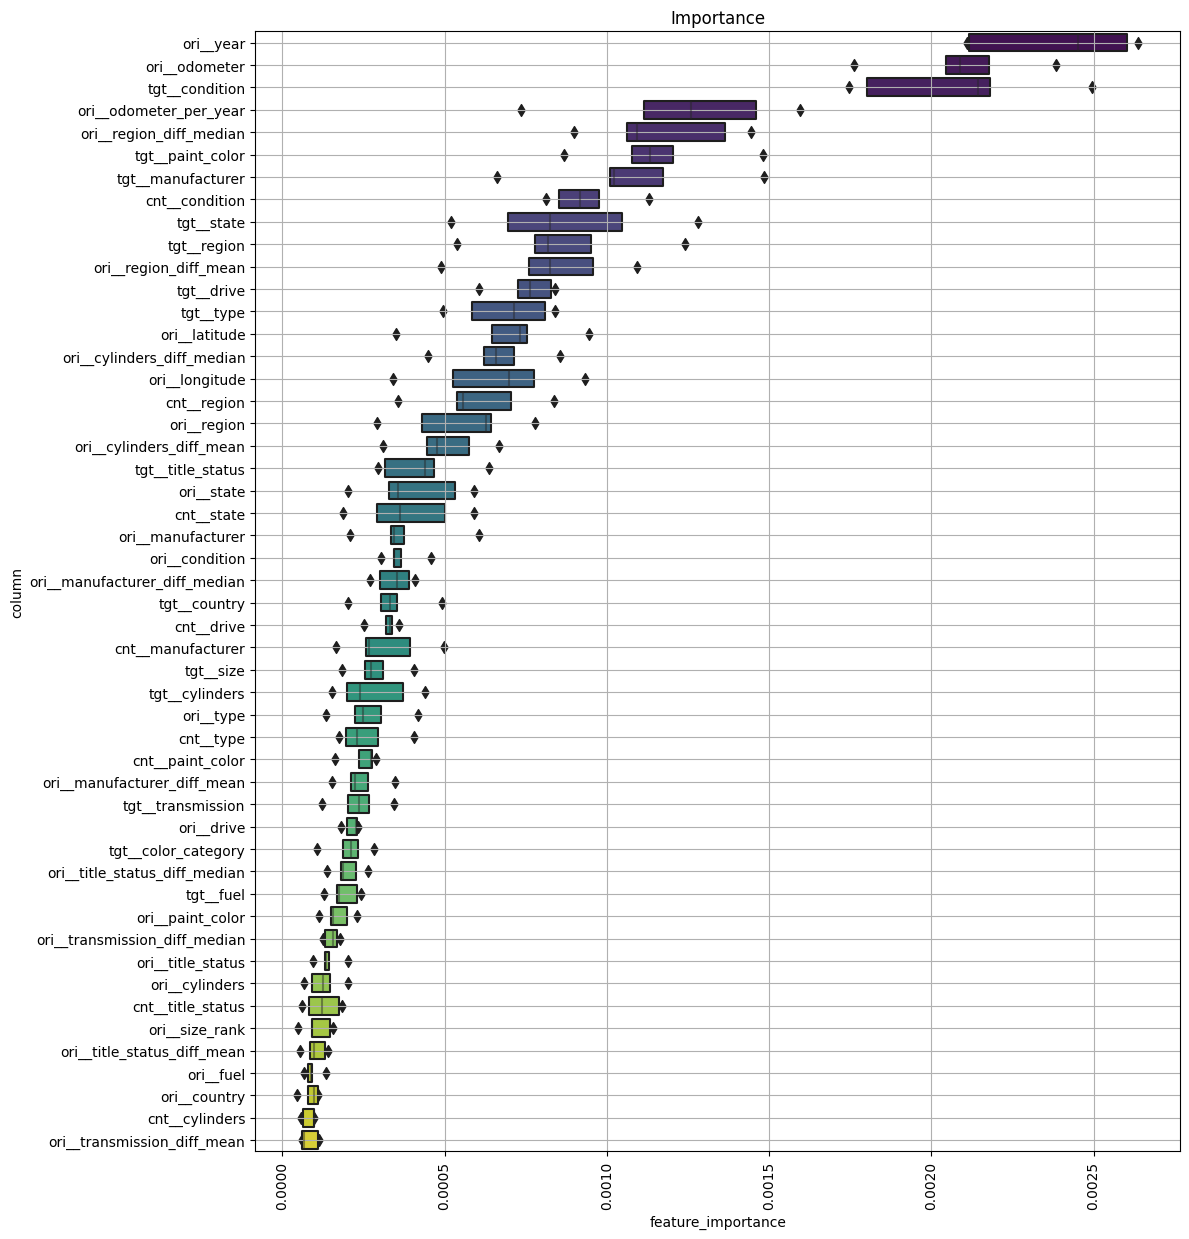

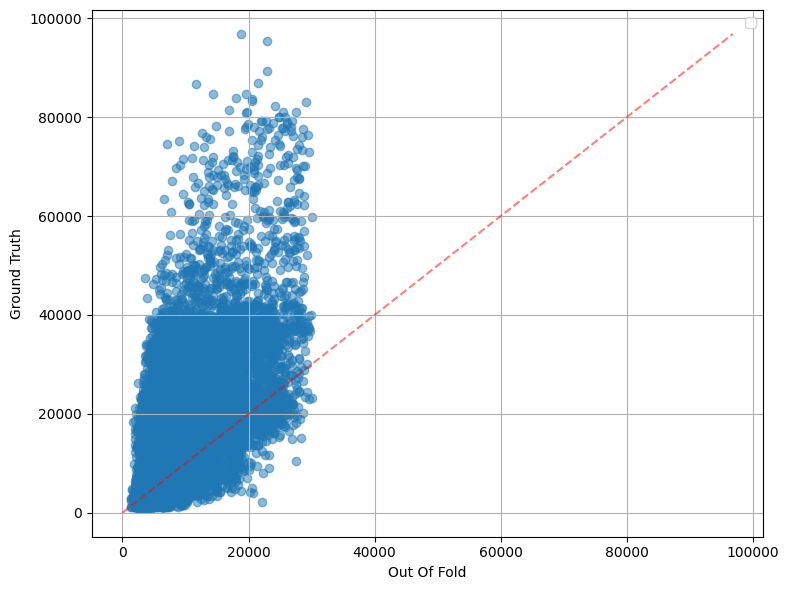

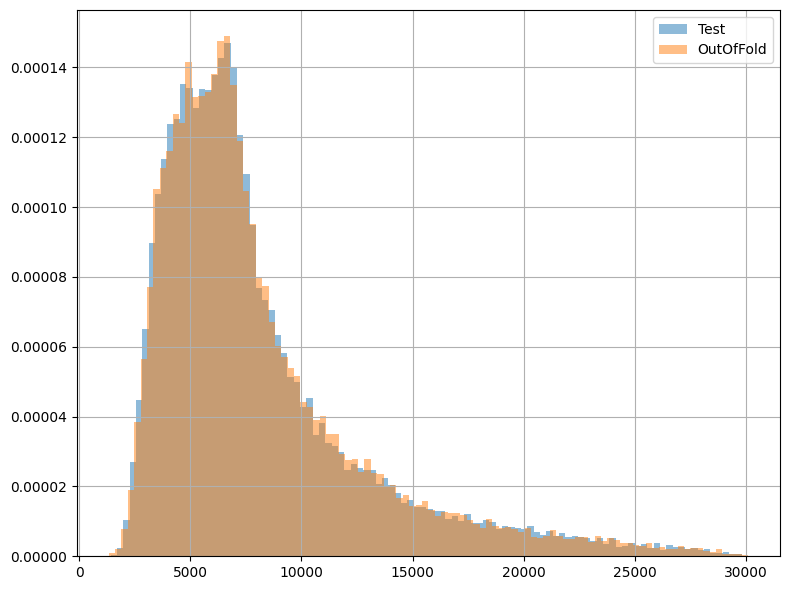

In [161]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)